In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from sklearn.impute import SimpleImputer 
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.impute import KNNImputer 

In [3]:
df = pd.read_csv('../data/data_clean.csv', sep=',', encoding='latin-1')
df = df.drop(columns=['PAQ706'])
df = df.drop(columns = ['CDQ001', 'CDQ010', 'DIQ070', 'DBD100', 'highLDL'])

#variable choice to create dataset for missignness simulation
df_nonmiss = df[['SEQN','RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3',
                 'DMDCITZN', 'DMDEDUC2', 'BMXLEG', 'BPXPULS',
                 'DIQ010', 'DIQ050', 'HIQ011', 'PAQ635', 
                 'PAQ650', 'PAQ665','PAD680', 'PAQ710', 'DR1TKCAL']] 

cont_cols = ['RIDAGEYR', 'BMXLEG', 'DR1TKCAL', 'PAD680']

#stash col mean, std in order to determine missingness in MAR and MNAR patterns
paq650mean = df_nonmiss['PAQ650'].mean()
paq650std = df_nonmiss['PAQ650'].std()

# Normalize continuous columns to standard Normal 
for cont_col in cont_cols: 
    df_nonmiss[cont_col] = (df_nonmiss[cont_col] - df_nonmiss[cont_col].mean()) / df_nonmiss[cont_col].std() 


np_nonmiss = df_nonmiss.to_numpy(copy=True, na_value=np.nan) # Convert dataframe to numpy array 
np_nonmiss = np_nonmiss[~np.isnan(np_nonmiss).any(axis=1), :] # delete rows with any missing values

seqn = np_nonmiss[:, 0] #record seqn for rows in df_nonmiss
np_nonmiss = np_nonmiss[:, 1:18] #remove seqn
#print(np.shape(np_nonmiss))
print(np_nonmiss)

[[ 1.13241831  1.          4.         ...  0.90678608  2.
  -0.52543534]
 [ 0.27835981  1.          3.         ...  0.60402997  4.
   2.84293864]
 [ 1.30323001  1.          3.         ... -0.60699445  4.
  -0.36223144]
 ...
 [ 1.75872788  1.          3.         ... -0.30423834  2.
   0.3031383 ]
 [-1.31588273  1.          2.         ...  0.90678608  2.
   2.48079981]
 [-0.40488699  2.          4.         ...  1.51229829  5.
   0.34466356]]


/var/folders/_1/dc2yd0kn325bph09grgy33lr0000gn/T/ipykernel_13265/992438590.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonmiss[cont_col] = (df_nonmiss[cont_col] - df_nonmiss[cont_col].mean()) / df_nonmiss[cont_col].std()


In [4]:
#proportion missing
p = 0.1 

#MCAR
MCAR_data = np.copy(np_nonmiss) #init data
MCAR_missing_indices = np.random.choice( # randomly select values from length ie flat array 
    len(np_nonmiss.flatten()), 
    size=int(len(np_nonmiss.flatten())*p)) 

MCAR_data.flat[MCAR_missing_indices] = np.nan 
print(MCAR_missing_indices)

[25122 48747 69793 ...  2909 57640 80450]


In [5]:
MNAR_data = np.copy(np_nonmiss) #init data

#find bmi values
bmi = df.loc[df['SEQN'].isin(seqn)]['bmi'] #limit to subset in seqn, select col bmi
bmi = bmi.to_numpy(copy=True, na_value=np.nan)

#high bmi
hibmi = (bmi > 25) #def of obesity
#health bmi
hebmi = (bmi < 25)

#determine indicies with hi or low bmi values
hibmi_ind = np.where(hibmi)[0]
hebmi_ind = np.where(hebmi)[0]

#randomly select indices for missing values
MNAR_missing_diet_ind = np.random.choice(len(hibmi_ind),
                                        size = round(len(hibmi_ind)*2*p/3)) #oversample hi bmi
np.append(MNAR_missing_diet_ind, 
          np.random.choice(len(hebmi_ind),
                           size = round(len(hebmi_ind)*p/3))) 


#remove those values from dataset
for i in MNAR_missing_diet_ind: 
    MNAR_data[i, 16] = np.nan #16 col is DR1TKCAL

# record indices where missing values occur
MNAR_missing_indices = np.where(np.isnan(MNAR_data.flatten()))[0].tolist()
#print(MNAR_missing_indices[0].tolist())

In [6]:
#MAR

# When data are MAR, the fact that the data are missing is systematically related to the observed
# but not the unobserved data, eg. related to age 

MAR_data = np.copy(np_nonmiss) #init data

#determine indicies with PAQ values
PAQ1_ind = np.where(np_nonmiss[:, 12] == 1) #12 col is PAQ650
PAQ2_ind = np.where(np_nonmiss[:, 12] == 2)

#randomly select indices for missing values
MAR_missing_diet_ind = np.random.choice(len(PAQ1_ind[0]),
                                        size = round(len(PAQ1_ind[0])*p/3))
np.append(MAR_missing_diet_ind, 
          np.random.choice(len(PAQ2_ind[0]),
                           size = round(len(PAQ2_ind[0])*2*p/3))) #more PAQ=2 are missing

#remove those values from dataset
for i in MAR_missing_diet_ind: 
    MAR_data[i, 16] = np.nan #16 col is DR1TKCAL

    # record indices where missing values occur
MAR_missing_indices = np.where(np.isnan(MAR_data.flatten()))[0].tolist()
    

In [7]:
def fit_low_rank_model(rank, rating_matrix_ini, train_ind, train_data, n_iter, convergence_thresh, verbose):
    previous_fitting_error = 100
    low_rank_estimate = np.zeros(rating_matrix_ini.shape) - 1 
    low_rank_estimate = rating_matrix_ini.copy() 
                
    for ind in range(n_iter): 
        M = low_rank_estimate.copy() 
        M.flat[train_ind] = rating_matrix_ini.flat[train_ind] 
        u, s, vh = np.linalg.svd(M) 
        low_rank_estimate = u[:, :rank] * s[:rank] @ vh[:rank, :]
        
        fitting_error = np.sqrt(np.mean(np.square(rating_matrix_ini.flat[train_ind] - 
                                                  low_rank_estimate.flat[train_ind])))         
        if verbose:
            print("Iteration " + str(ind) + " Error: " + str(fitting_error))
        
        if abs(fitting_error-previous_fitting_error) <= convergence_thresh: 
            print('Rank:', rank, '\t Stopping at: ', ind)
            break 
        previous_fitting_error = fitting_error 
        
    return low_rank_estimate 

In [8]:
def run_svd(matrix, missing_indices, 
        n_test = 100, 
        n_val = 100, 
        n_iter = 500,
        convergence_thresh=1e-4
       ): 
    n_train = matrix.shape[0] - n_test - n_val

    nonmissing_indices = np.argwhere(~np.isnan(matrix.flatten())).reshape(-1) 

    aux_ind = nonmissing_indices[np.random.permutation(np.arange(len(nonmissing_indices)))]
    test_ind = aux_ind[:n_test]
    val_ind = aux_ind[n_test:(n_test+n_val)]
    train_ind = aux_ind[(n_test+n_val):(n_test+n_val+n_train)]

    train_set = matrix.flat[train_ind] 
    val_set = matrix.flat[val_ind]
    test_set = matrix.flat[test_ind]

    # make imputed rating matrix (training data) as initialization
    matrix_ini = np.zeros(matrix.shape) - 1 
    matrix_ini.flat[train_ind] = train_set 

    ## Impute missing values with column mean to begin with 
    col_mean = [np.mean(col[col>-1]) for col in matrix_ini.T]
    inds = np.where(matrix_ini == -1) 
    matrix_ini[inds] = np.take(col_mean, inds[1]) 
        
    ranks = np.arange(1, 10, 1)
    train_error = np.zeros(len(ranks))
    val_error = np.zeros(len(ranks))
    
    for ind,rank in enumerate(ranks):
        # print("Rank " + str(rank))
        estimate = fit_low_rank_model(rank, 
                                      matrix_ini, 
                                      train_ind, 
                                      train_set, 
                                      n_iter, 
                                      convergence_thresh, 
                                      verbose=False)

        train_error[ind] = mean_squared_error(train_set, estimate.flat[train_ind])  
        val_error[ind] = mean_squared_error(val_set, estimate.flat[val_ind]) 

    markersize = 10
    font_size = 25
    font_size_ticks = 22
    plt.figure(figsize=(12,9))
    plt.plot(ranks, train_error, linestyle="None", marker='o', ms=markersize, color="black", markeredgewidth=2,
                         markerfacecolor="black",label="Training error")
    plt.plot(ranks, val_error, linestyle="None", marker='o', ms=markersize, color="black", markeredgewidth=2,
                         markerfacecolor="white", label="Validation error")
    plt.ylabel('Root mean squared error', fontsize=font_size, labelpad=10)
    plt.xlabel('Rank', fontsize=font_size, labelpad=10)
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    #plt.ylim([0,1.1])
    plt.legend(fontsize=font_size)
    plt.show() 
    # plt.savefig('plots/errors.pdf',bbox_inches="tight") 
    
    best_rank = np.argmin(val_error)+1  
    print('best_rank: ', best_rank)
    best_estimate = fit_low_rank_model(best_rank, 
                                       matrix_ini, 
                                       train_ind, 
                                       train_set, 
                                       n_iter, 
                                       convergence_thresh, 
                                       verbose=False)

    test_error = mean_squared_error(test_set, best_estimate.flat[test_ind]) 
    print("test error of low-rank estimate: " + str(np.round(test_error,3))) 
        
    return best_estimate 

In [9]:
def run(data, missing_indices, method, simulation=False): 
    if method in ['mean', 'most_frequent', 'median']: 
        imp = SimpleImputer(missing_values=np.nan, strategy=method)
        imputed_data = imp.fit_transform(data)
        
    if method == "multivariate_feature_imputation": 
        imp = IterativeImputer(max_iter=50, random_state=0) 
        imputed_data = imp.fit_transform(data) 

    if method == "knn": 
        imputer = KNNImputer(n_neighbors=2, weights="uniform") 
        imputed_data = imputer.fit_transform(data) 
    
    if method == "svd": 
        imputed_data = run_svd(matrix=data, missing_indices=missing_indices) 
        
    # print(imputed_data[:3,:3])         
    if simulation: 
        print("MSE = ", mean_squared_error(
            np_nonmiss.flat[missing_indices], 
            imputed_data.flat[missing_indices])) 
    return imputed_data


    

In [10]:
data_dict = {
    "MCAR_data":[MCAR_data, MCAR_missing_indices], 
    "MAR_data":[MAR_data, MAR_missing_indices], 
    "MNAR_data":[MNAR_data, MNAR_missing_indices], 
}

Data:  MCAR_data 


method: svd
Rank: 1 	 Stopping at:  69
Rank: 2 	 Stopping at:  146
Rank: 3 	 Stopping at:  223
Rank: 4 	 Stopping at:  182
Rank: 5 	 Stopping at:  174
Rank: 6 	 Stopping at:  132
Rank: 7 	 Stopping at:  115
Rank: 8 	 Stopping at:  100
Rank: 9 	 Stopping at:  96


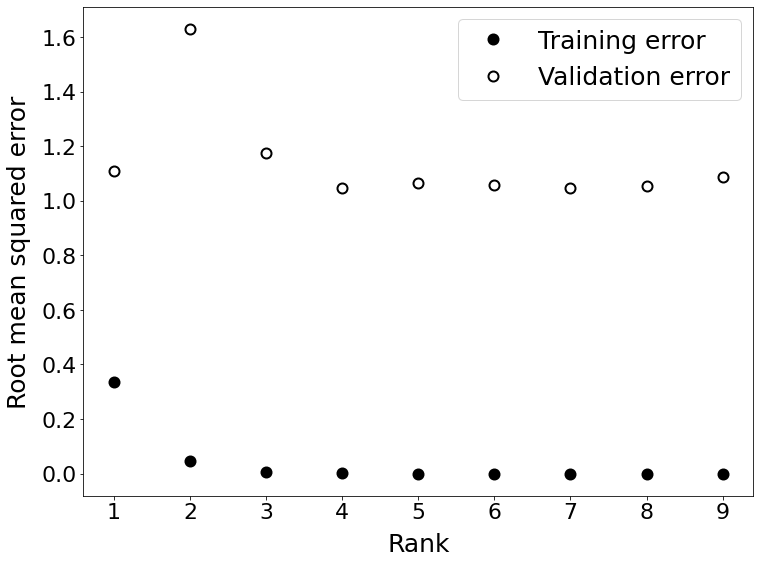

best_rank:  4
Rank: 4 	 Stopping at:  182
test error of low-rank estimate: 0.795
MSE =  1.0205664065153384

Data:  MAR_data 


method: svd
Rank: 1 	 Stopping at:  85
Rank: 2 	 Stopping at:  175
Rank: 3 	 Stopping at:  218
Rank: 4 	 Stopping at:  228
Rank: 5 	 Stopping at:  185
Rank: 6 	 Stopping at:  128
Rank: 7 	 Stopping at:  104
Rank: 8 	 Stopping at:  90
Rank: 9 	 Stopping at:  77


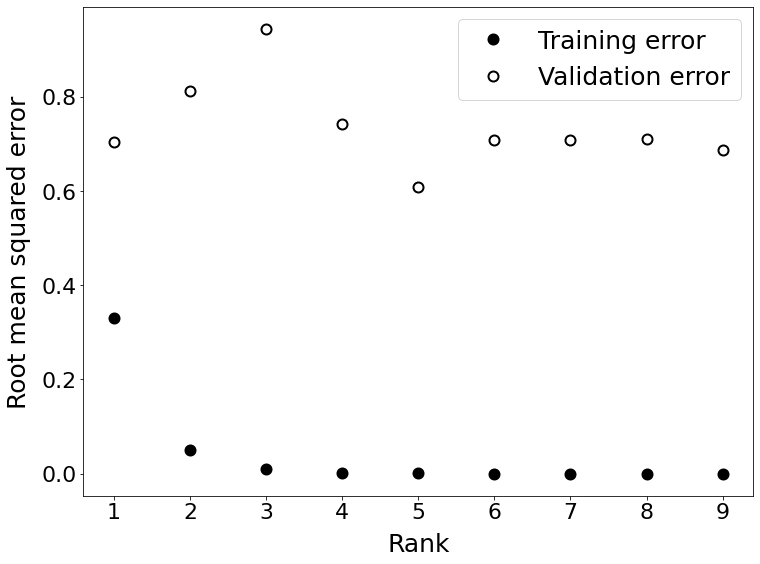

best_rank:  5
Rank: 5 	 Stopping at:  185
test error of low-rank estimate: 1.308
MSE =  1.0594733482500271

Data:  MNAR_data 


method: svd
Rank: 1 	 Stopping at:  55
Rank: 2 	 Stopping at:  145
Rank: 3 	 Stopping at:  228
Rank: 4 	 Stopping at:  175
Rank: 5 	 Stopping at:  161
Rank: 6 	 Stopping at:  118
Rank: 7 	 Stopping at:  103
Rank: 8 	 Stopping at:  82
Rank: 9 	 Stopping at:  77


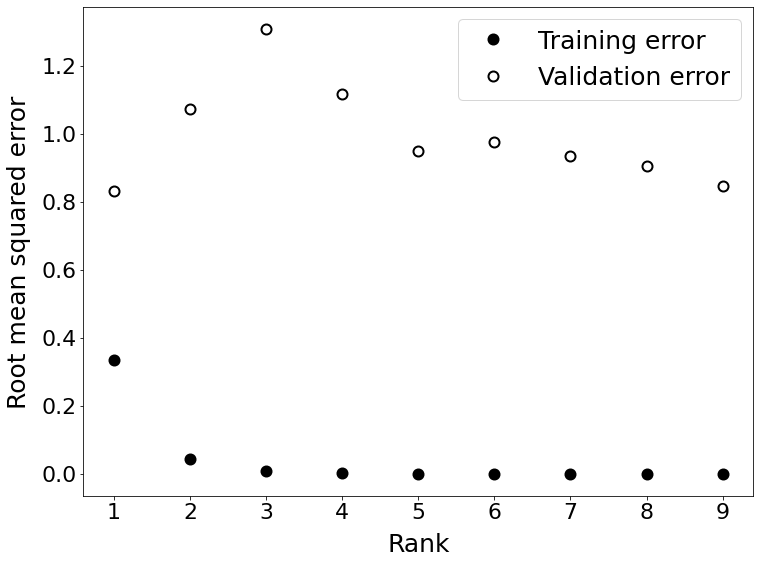

best_rank:  1
Rank: 1 	 Stopping at:  55
test error of low-rank estimate: 1.528
MSE =  1.0099448165367546



In [11]:
for key in data_dict.keys(): 
    print("=============================================")
    print("Data: ", key, "\n\n")
    for method in ['svd']: 
#     for method in ['mean', 'median', 'most_frequent', 'multivariate_feature_imputation', 'knn', 'svd']: 
        print('method:', method)
        run(data_dict[key][0], data_dict[key][1], method, simulation=True)
        print() 
    print("=============================================")

# Regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def linear_regression(x_train, x_test, y_train, y_test):
    model = LinearRegression().fit(x_train, y_train)
    r_sq = model.score(x_train, y_train)
    # print('coefficient of determination:', r_sq) 
    y_pred_train = model.predict(x_train) 
    y_pred_test = model.predict(x_test) 
    # print(np.linalg.norm(y_pred - y_test))

    # errors train 
    print('Mean Absolute Error - Training:', metrics.mean_absolute_error(y_pred_train, y_train))
    print('Mean Squared Error - Training:', metrics.mean_squared_error(y_pred_train, y_train))
    print('Root Mean Squared Error - Training:', np.sqrt(metrics.mean_squared_error(y_pred_train, y_train)))

    # error test
    print('Mean Absolute Error - Test:', metrics.mean_absolute_error(y_pred_test, y_test))
    print('Mean Squared Error - Test:', metrics.mean_squared_error(y_pred_test, y_test))
    print('Root Mean Squared Error - Test:', np.sqrt(metrics.mean_squared_error(y_pred_test, y_test)))

In [13]:
df = pd.read_csv('../data/data_clean.csv', sep=',', encoding='latin-1')
df = df.drop(columns=['PAQ706', 'SEQN'])
df = df[df.BPXSY1.notnull()] 
y_label = df.BPXSY1.to_numpy() 
df = df.drop(columns=['BPXSY1'])
X = df.to_numpy(copy=True, na_value=np.nan) # Convert dataframe to numpy array 
missing_indices = np.argwhere(np.isnan(X.flatten())).reshape(-1) 

************ mean ************
Mean Absolute Error - Training: 10.97892662219659
Mean Squared Error - Training: 210.74108753630404
Root Mean Squared Error - Training: 14.516924176157428
Mean Absolute Error - Test: 11.218624032176757
Mean Squared Error - Test: 218.54954776091927
Root Mean Squared Error - Test: 14.78342138210635
************ median ************
Mean Absolute Error - Training: 11.148281123262246
Mean Squared Error - Training: 218.35741945199857
Root Mean Squared Error - Training: 14.776921853078827
Mean Absolute Error - Test: 10.975552003183898
Mean Squared Error - Test: 202.42557667734118
Root Mean Squared Error - Test: 14.2276342614414
************ most_frequent ************
Mean Absolute Error - Training: 11.024248149313307
Mean Squared Error - Training: 212.37726595410254
Root Mean Squared Error - Training: 14.573169386036193
Mean Absolute Error - Test: 11.041789152814413
Mean Squared Error - Test: 213.72844884665875
Root Mean Squared Error - Test: 14.619454464741793


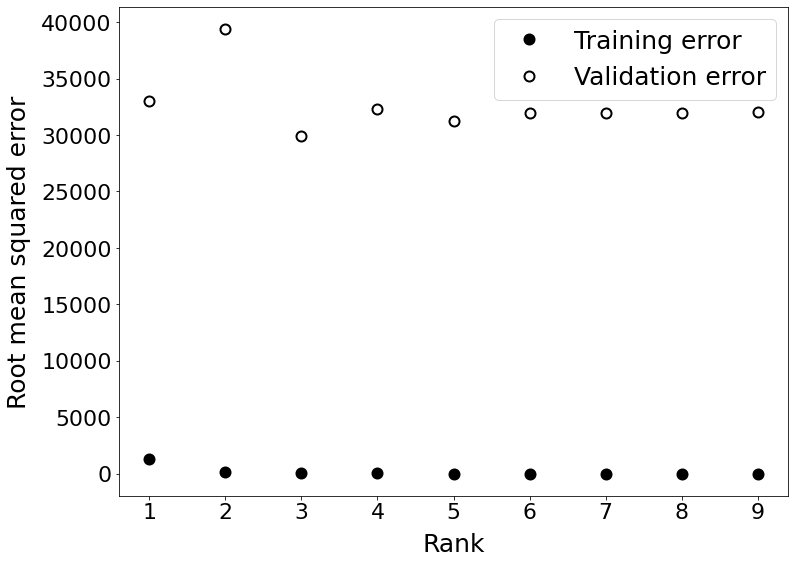

best_rank:  3
test error of low-rank estimate: 30770.474
************ svd ************
Mean Absolute Error - Training: 13.96727136163663
Mean Squared Error - Training: 332.41141495492263
Root Mean Squared Error - Training: 18.232153327430158
Mean Absolute Error - Test: 13.738744587573468
Mean Squared Error - Test: 318.79500438899663
Root Mean Squared Error - Test: 17.85483140186422


In [14]:
for method in ['mean' , 'median', 'most_frequent', 'knn', 'multivariate_feature_imputation', 'svd']:  
    estimate = run(X, missing_indices, method)
    x_train, x_test, y_train, y_test = train_test_split(estimate, y_label, test_size=0.3) 
    print(f'************ {method} ************')
    linear_regression(x_train, x_test, y_train, y_test) 